In [4]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
import cv2
import random

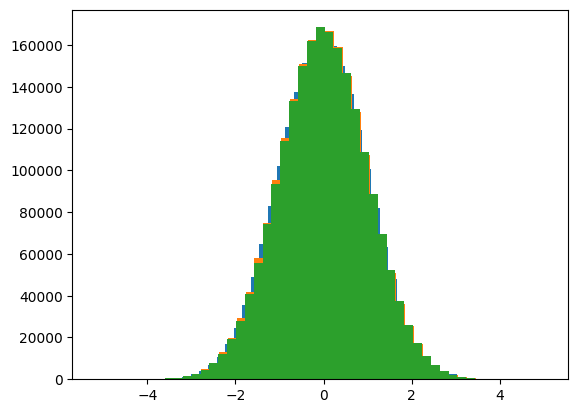

In [5]:
r = np.random.randn(128, 128, 128, 3)
plt.hist(r[..., 0].flatten(), bins=50)
plt.hist(r[..., 1].flatten(), bins=50)
plt.hist(r[..., 2].flatten(), bins=50)
plt.show()

In [9]:
images = glob.glob("/home/student/andrewheschl/Documents/Datasets/ClassificationDataset/preprocessed/Dataset_large_421/fold_0/train/imagesTr/*")
random.shuffle(images)
img = np.stack([cv2.resize(np.load(x)[:, 0:512, 0:512].transpose((1, 2, 0)), (128, 128), interpolation=cv2.INTER_CUBIC) for x in images[0:64]], axis=0)

In [10]:
img -= np.min(img)
img /= np.max(img)
img*=255
print(img.min(), img.max())

0.0 255.0


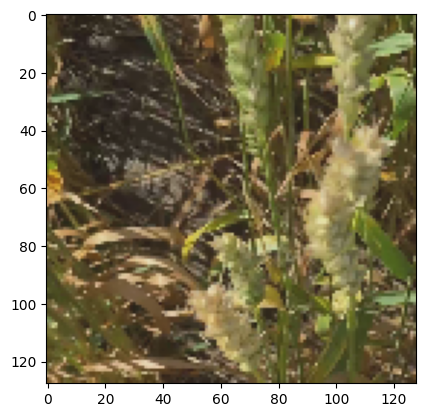

In [11]:
plt.imshow(img[0].astype(np.uint8))

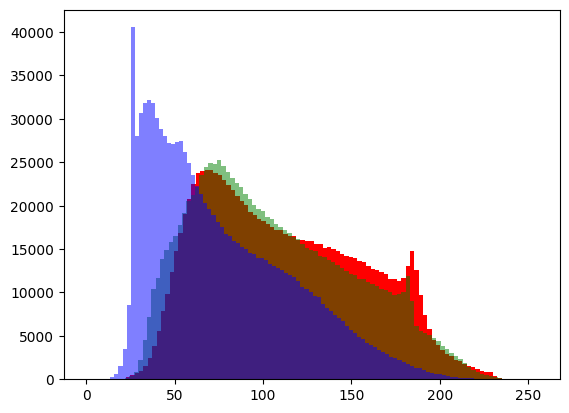

In [12]:

plt.hist(img[:, :, :, 0].flatten(), bins=101, color='r')
plt.hist(img[:, :, :, 1].flatten(), bins=101, color='g', alpha=0.5)
plt.hist(img[:, :, :, 2].flatten(), bins=101, color='b', alpha=0.5)
plt.show()

In [13]:
import pandas as pd
import seaborn as sns

def plot_b(color, alpha=1, epoch=-1):
    data = pd.read_csv(f"./inference_bins_{color}.csv")
    recent = data.iloc[epoch][f"concat_no_gan_slow_lr - generated {str(color).upper()} distribution"]
    recent = eval(recent)
    values = recent["values"]
    bins = recent["bins"]
    print(len(bins), len(values))
    print(len(bins))
    # plot the precomputed values and bins to a histogram using seaborn or matplotlib. sns.histplot(values, bins=bins) is not working properly
    # sns.histplot(values, bins=bins) and neither is plt.hist(values, bins=bins)
    # this is because the values are already binned by wandb
    # so we can use plt.bar to plot the values
    plt.bar(bins[:-1], values, width=np.diff(bins), color=color, alpha=alpha)

def get_histogram(color, epoch, alpha=1):
    data = pd.read_csv(f"./inference_bins_{color}.csv")
    recent = data.iloc[epoch][f"concat_no_gan_slow_lr - generated {str(color).upper()} distribution"]
    recent = eval(recent)
    values = recent["values"]
    bins = recent["bins"]
    return values, bins



65 64
65
65 64
65
65 64
65


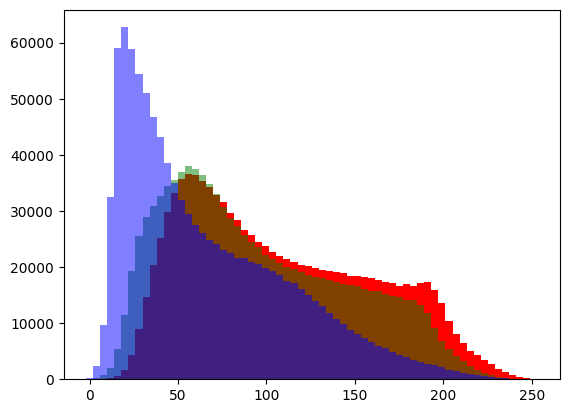

In [14]:
plot_b("r")
plot_b("g", alpha=0.5)
plot_b("b", alpha=0.5)


In [15]:
real_r_hist = np.histogram(img[:, :, :, 0].flatten(), bins=64)
real_g_hist = np.histogram(img[:, :, :, 1].flatten(), bins=64)
real_b_hist = np.histogram(img[:, :, :, 2].flatten(), bins=64)

generated_r_hist = get_histogram('r', -1)
generated_g_hist = get_histogram('g', -1)
generated_b_hist = get_histogram('b', -1)

In [16]:
# kl divergence
def kl_divergence(p, q):
    smooth = 1e-10
    p = p / np.sum(p)
    q = q / np.sum(q)
    return np.sum(p * np.log((p + smooth) / (q + smooth)))

def js_divergence(p, q):
    p = p / np.sum(p)
    q = q / np.sum(q)
    
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [17]:
epochs = len(pd.read_csv(f"./inference_bins_r.csv"))
print(epochs)
r_divergences = [js_divergence(real_r_hist[0], get_histogram('r', i)[0]) for i in range(epochs)]
g_divergences = [js_divergence(real_g_hist[0], get_histogram('g', i)[0]) for i in range(epochs)]
b_divergences = [js_divergence(real_b_hist[0], get_histogram('b', i)[0]) for i in range(epochs)]

400


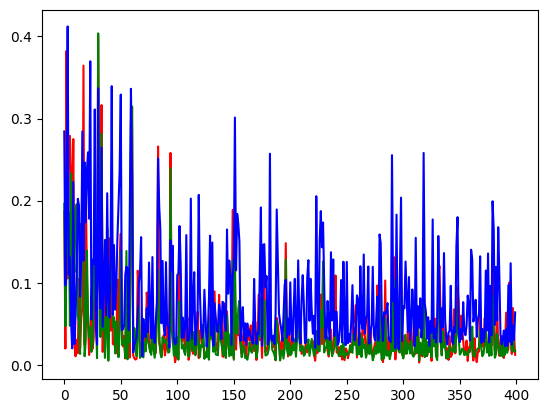

In [18]:
# plot r_divergences
plt.plot(r_divergences, color='r')
plt.plot(g_divergences, color='g')
plt.plot(b_divergences, color='b')
plt.show()

In [19]:
# remove outliers
r_divergences = np.array(r_divergences)
g_divergences = np.array(g_divergences)
b_divergences = np.array(b_divergences)

r_divergences_clean = r_divergences[r_divergences < 0.3]
g_divergences_clean = g_divergences[g_divergences < 0.3]
b_divergences_clean = b_divergences[b_divergences < 0.3]

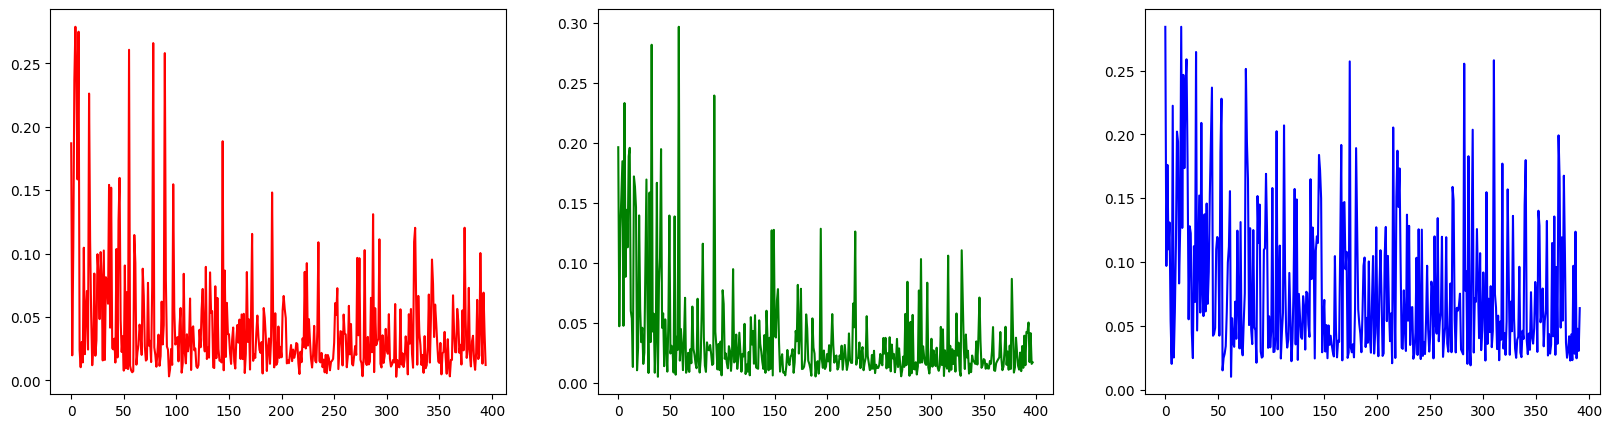

In [20]:
_, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].plot(r_divergences_clean, color='r')
ax[1].plot(g_divergences_clean, color='g')
ax[2].plot(b_divergences_clean, color='b')

In [21]:
# ema of divergences
def ema(data, alpha=0.99):
    ema = [data[0]]
    for i in range(1, len(data)):
        ema.append(alpha * ema[-1] + (1 - alpha) * data[i])
    return ema

r_divergences_ema = ema(r_divergences)
g_divergences_ema = ema(g_divergences)
b_divergences_ema = ema(b_divergences)

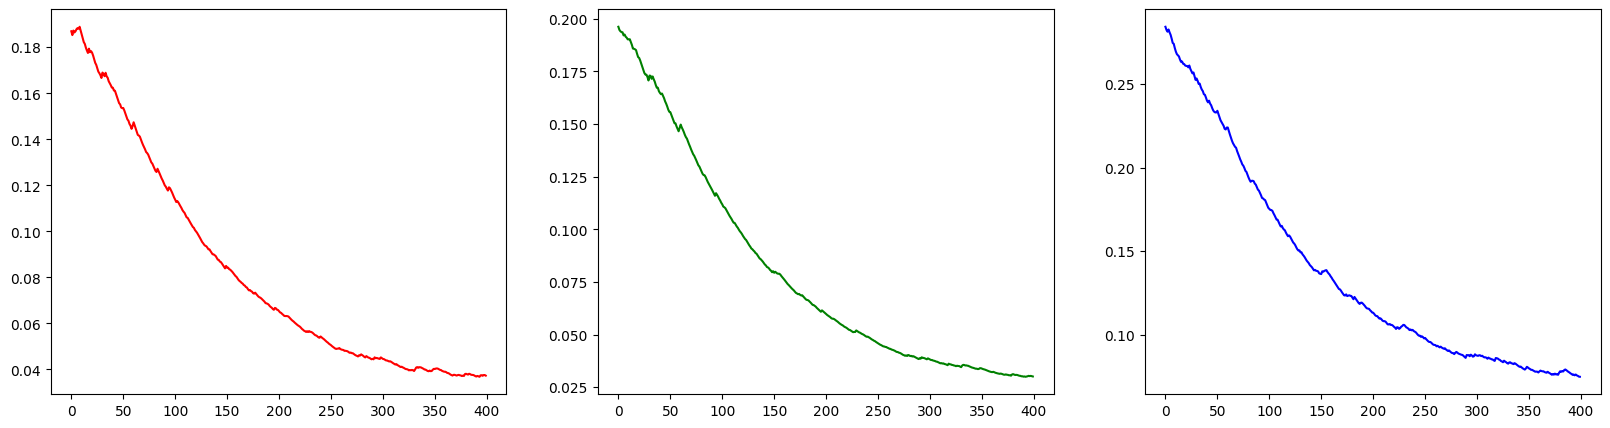

In [22]:
_, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].plot(r_divergences_ema, color='r')
ax[1].plot(g_divergences_ema, color='g')
ax[2].plot(b_divergences_ema, color='b')

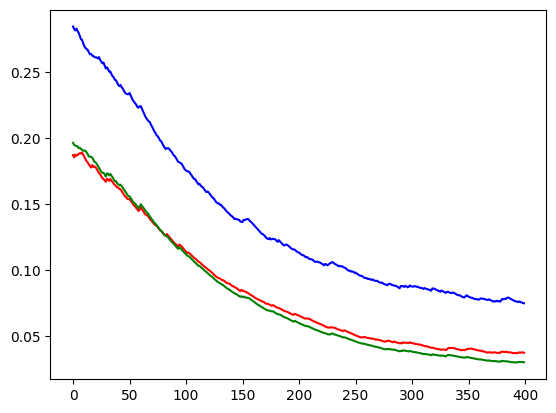

In [23]:
plt.plot(r_divergences_ema, color='r')
plt.plot(g_divergences_ema, color='g')
plt.plot(b_divergences_ema, color='b')
plt.show()

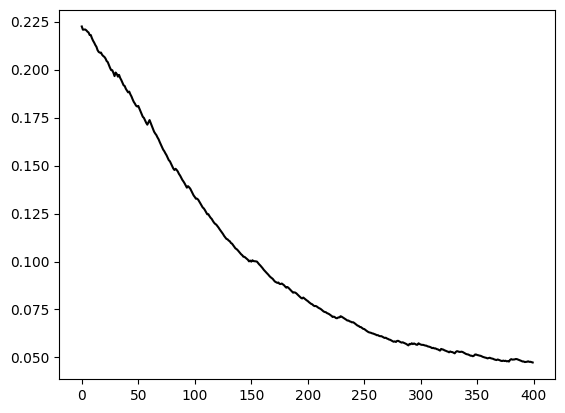

In [31]:
r_divergences_ema = np.array(r_divergences_ema)
g_divergences_ema = np.array(g_divergences_ema)
b_divergences_ema = np.array(b_divergences_ema)

average_of_divergences = (r_divergences_ema + g_divergences_ema + b_divergences_ema) / 3
plt.plot(average_of_divergences, color='black')

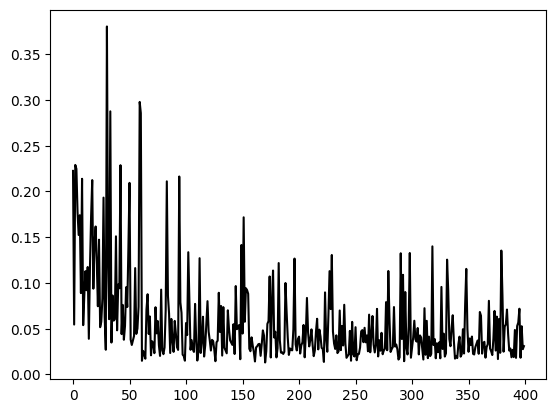

In [33]:
# avergae
r_divergences = np.array(r_divergences)
g_divergences = np.array(g_divergences)
b_divergences = np.array(b_divergences)

average_of_divergences = (r_divergences + g_divergences + b_divergences) / 3
plt.plot(average_of_divergences, color='black')

170
   Step   concat_no_gan_slow_lr - generated R distribution
0     2  {"_type":"histogram","values":[43,9,7,18,23,31...
1     7  {"values":[50,86,215,408,903,1808,3331,5415,84...
2    12  {"values":[2,2,2,5,3,4,7,11,18,21,28,43,67,65,...
3    17  {"values":[96,49,58,93,126,157,254,337,469,664...
4    22  {"_type":"histogram","values":[8,15,19,30,56,9...
Step                                                                                              852
concat_no_gan_slow_lr - generated R distribution    {"values":[11,27,96,261,752,1871,3858,6677,991...
Name: 170, dtype: object
65 64
65
65 64
65
65 64
65


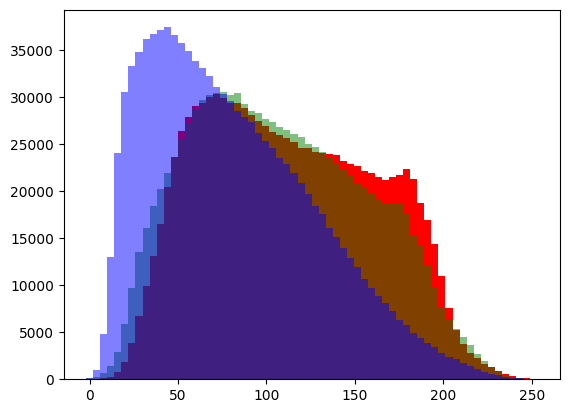

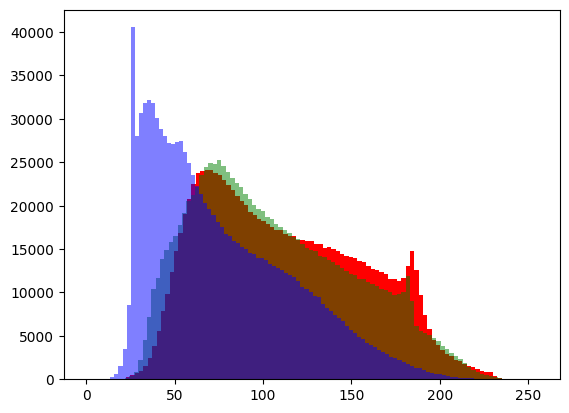

In [35]:
# epoch of minimum average
min_epoch = np.argmin(average_of_divergences[100:])+100
print(min_epoch)
# show this row
data = pd.read_csv(f"./inference_bins_r.csv")
print(data.head())
print(data.iloc[min_epoch])
# plot the hisotgrams at this row
plot_b("r", epoch=min_epoch)
plot_b("g", alpha=0.5, epoch=min_epoch)
plot_b("b", alpha=0.5, epoch=min_epoch)
plt.show()

plt.hist(img[:, :, :, 0].flatten(), bins=101, color='r')
plt.hist(img[:, :, :, 1].flatten(), bins=101, color='g', alpha=0.5)
plt.hist(img[:, :, :, 2].flatten(), bins=101, color='b', alpha=0.5)
plt.show()

In [27]:
# best epoch for r
r_divergences = np.array(r_divergences)
min_epoch = np.argmin(r_divergences)
print(min_epoch)
data = pd.read_csv(f"./inference_bins_r.csv")
print(data.iloc[min_epoch])


314
Step                                                                                             1572
concat_no_gan_slow_lr - generated R distribution    {"_type":"histogram","values":[5,27,74,252,631...
Name: 314, dtype: object


In [28]:
# best epoch for g
g_divergences = np.array(g_divergences)
min_epoch = np.argmin(g_divergences)
print(min_epoch)
data = pd.read_csv(f"./inference_bins_g.csv")
print(data.iloc[min_epoch])


39
Step                                                                                              197
concat_no_gan_slow_lr - generated G distribution    {"_type":"histogram","values":[38,98,297,785,2...
Name: 39, dtype: object


In [29]:
# best epoch for b
b_divergences = np.array(b_divergences)
min_epoch = np.argmin(b_divergences)
print(min_epoch)
data = pd.read_csv(f"./inference_bins_b.csv")
print(data.iloc[min_epoch])


69
Step                                                                                              347
concat_no_gan_slow_lr - generated B distribution    {"values":[56,183,688,2647,7885,17243,27081,33...
Name: 69, dtype: object


In [ ]:
print()